### ДЗ NLP 2

Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

- тест на определение ближайших слов
- тест на аналогии (мужчина – король : женщина – королева)
- тест на определение лишнего слова.


Постройте несколько визуализаций:

  - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
  - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

### Подготовка текста

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip3 install pymorphy2

In [3]:
!pip install rusenttokenize

In [4]:

responses = []
with bz2.BZ2File('/content/drive/MyDrive/ML/nlp/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:24, 2383.46it/s]


In [5]:
def py_normalform(text):
    try:
        nf = [pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split()]
        return " ".join(nf)
    except:
        return ""

def py_tag(text):
          return [[word, pymorphy2_analyzer.parse(word)[0].tag]  for word in text.split()]


In [6]:
import re
regex = re.compile("[А-Яа-я.!?]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

regex_clear = re.compile("[А-Яа-я]+")

def words_only_clear(text, regex=regex_clear):
    return " ".join(regex.findall(text))


In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

print(mystopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'на

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
from nltk.tokenize import sent_tokenize
from rusenttokenize import ru_sent_tokenize
from nltk.tokenize import word_tokenize
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [11]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

Задаем количество отзывов для дальнейшего анализа

In [12]:
num_responses = 100000
n_chunk = 10000

In [13]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
      

chunked_list_ids=chunks(responses[0:num_responses],n_chunk)
for list_temp in chunked_list_ids: 
  for row in tqdm(list_temp):
    row.update(clear=py_normalform(remove_stopwords(words_only(row.get('text')))))


100%|██████████| 10000/10000 [04:56<00:00, 33.70it/s]


In [14]:
responses[0]

{'author': 'uhnov1',
 'bank_license': 'лицензия № 2562',
 'bank_name': 'Бинбанк',
 'city': 'г. Москва',
 'clear': 'добрый день! я являться клиент банк поручитель кредитный договор являться какой либо другой лицо письменно оформить отношение банк повод урегулирование чей либо задолженности. начинать март год начать приходить бесконечный письмо ооо прить коллект адрес город москва уваровский переулок дом квартира угроза возбуждение уголовный дело отношение гражданин филиппов эдуард владимирович который уклоняться уплата взять кредит договор . . год договор . . года. с весь ответственность хотеть вы заверить вышеуказанный гражданин который вы разыскивать знак мой адрес зарегистрирован. какой образ вы удостовериться подлинность документ оформить имя кредитный договор малый мера понятно почему ваш милость должный переживать бояться свой имущество. письмо доставлять серьёзный неудобство нарушать мой гражданский право нарушать закон защита персональный данных. убедительно просить прекратить п

Лемматизированные тексты разбиваем на предложения

In [15]:
chunked_list_ids=chunks(responses[0:num_responses],n_chunk)
for list_temp in chunked_list_ids: 
  for row in tqdm(list_temp):
    row.update(sent=sent_tokenize(row.get('clear')))


100%|██████████| 10000/10000 [00:06<00:00, 1520.47it/s]


In [16]:
#chunked_list_ids=chunks(responses[0:10000],100)
#for list_temp in chunked_list_ids: 
#  for row in tqdm(list_temp):
#    row.setdefault('POS',[]).append(py_tag(row.get('clear')[0]))

In [66]:
df = pd.DataFrame(responses[0:num_responses])
df['rating_grade'] = df['rating_grade'].fillna(0)
df = df.drop(['bank_license','author','datetime','city','rating_not_checked','title',], 1)

In [67]:
df.text = df.text.str.lower()
df = df.assign(text_wo=lambda x: df.text.apply(words_only))
df = df.assign(text_wosw=lambda x: df.text_wo.apply(remove_stopwords))

#df.text = df.text.str.lower()
#df.text = df.text.apply(words_only)

In [68]:
corpus2 = [nltk.word_tokenize(sent) for sent in df.clear]

In [69]:
corpus2[23]

['в',
 'год',
 'банк',
 'втб',
 'приобрести',
 'серебряный',
 'монета',
 'проба',
 'знак',
 'зодиак',
 'рыба',
 '.',
 'возникнуть',
 'необходимость',
 'сдать',
 'монета',
 'обмен',
 'деньги',
 '.',
 'обратиться',
 'банк',
 'втб',
 'отказать',
 'связь',
 'банк',
 'прод',
 'монета',
 'покупать',
 'назад',
 '.',
 'обратиться',
 'сбербанк',
 'каталог',
 'наслать',
 'монету',
 '.',
 'что',
 'дальше',
 '?',
 '!']

### Построение модели



In [70]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [71]:
model = Word2Vec()

model.build_vocab(corpus2, progress_per=10)

model.train(corpus2,total_examples=model.corpus_count,  epochs=30, report_delay=1)


(424102589, 504407130)

- тест на определение ближайших слов
- тест на аналогии (мужчина – король : женщина – королева)

In [74]:
model.wv.similarity('банк', 'деньги')  #  схожесть двух слов

0.1176519

In [170]:
model.wv.most_similar(positive=["мужчина"])    # близкие слова

[('женщина', 0.8943132162094116),
 ('дама', 0.7677617073059082),
 ('парень', 0.7253227233886719),
 ('мужик', 0.7202972769737244),
 ('охранник', 0.7051090002059937),
 ('тётенька', 0.6886937618255615),
 ('посетительница', 0.6840378642082214),
 ('блондинка', 0.6755356788635254),
 ('девица', 0.6540517807006836),
 ('дяденька', 0.6533090472221375)]

In [171]:
model.wv.most_similar(negative=["мужчина"])    # отдаленные слова

[('пс', 0.42658278346061707),
 ('сохраняться', 0.38208332657814026),
 ('реализовать', 0.3791548013687134),
 ('доработать', 0.3573809564113617),
 ('использование', 0.34518536925315857),
 ('аннулироваться', 0.3447358310222626),
 ('компенсировать', 0.34270012378692627),
 ('изменить', 0.3423070013523102),
 ('скорректировать', 0.34158235788345337),
 ('подгрузить', 0.34090906381607056)]

In [136]:
reloaded_word_vectors.words_closer_than('сотрудник', 'думать')    #  все слова , которые ближе к "сотруднику",  чем слово "думать" к "сотруднику"

['.',
 'банк',
 '!',
 'карта',
 '?',
 'я',
 'мой',
 'в',
 'деньга',
 'который',
 'день',
 'кредит',
 'отделение',
 'клиент',
 'сказать',
 'сумма',
 'счёт',
 'заявление',
 '...',
 'свой',
 'год',
 'вопрос',
 'время',
 'кредитный',
 'мочь',
 'ваш',
 'такой',
 'номер',
 'получить',
 'быть',
 'ответ',
 'дать',
 'и',
 'договор',
 'телефон',
 'вклад',
 'офис',
 'звонить',
 'на',
 'платёж',
 'написать',
 'вы',
 'какой',
 'позвонить',
 'очень',
 'звонок',
 'средство',
 'г.',
 'но',
 'месяц',
 'смс',
 'банкомат',
 'прийти',
 'почему',
 'а',
 'один',
 'решить',
 'должный',
 'проблема',
 'другой',
 'говорить',
 'работа',
 'обратиться',
 'данный',
 'документ',
 'информация',
 'хотеть',
 'работать',
 'ситуация',
 'операция',
 'человек',
 'банка',
 'срок',
 'просить',
 'рубль',
 'сделать',
 'сегодня',
 'услуга',
 'руб',
 'заявка',
 'это',
 'просто',
 'первый',
 'являться',
 'никакой',
 'знать',
 'сообщить',
 'тот',
 'новый',
 'оператор',
 'претензия',
 'интернет',
 'ждать',
 'обслуживание',
 'весь',

In [75]:
vector = model.wv['день']  
sims1 = model.wv.most_similar('сотрудник', topn=10)  

Для работы с веторами сохраняем модель, потом загружаем

In [76]:
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

word_vectors = model.wv
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')


- тест на определение лишнего слова.


In [168]:
def odd_word_out(input_words):
    '''The function accepts a list of word and returns the odd word.'''
     
    # Generate all word embeddings for the given list of words
     
    whole_word_vectors = [reloaded_word_vectors[i] for i in input_words]
     
    # average vector for all word vectors
    mean_vector = np.mean(whole_word_vectors,axis=0)
     
    # Iterate over every word and find similarity
    odd_word = None
    minimum_similarity = 99999.0 # Can be any very high value
     
    for i in input_words:
        similarity = cosine_similarity([reloaded_word_vectors[i]],[mean_vector])
        if similarity < minimum_similarity:
            minimum_similarity = similarity
            odd_word = i
     
        print("cosine similarity score between %s and mean_vector is %.3f"%(i,similarity))
     
    print("\nЛишнее слово: "+odd_word)

In [169]:
input_1 = ['банк','деньги','день','банкомат','взять'] 
odd_word_out(input_1)

cosine similarity score between банк and mean_vector is 0.311
cosine similarity score between деньги and mean_vector is 0.577
cosine similarity score between день and mean_vector is 0.481
cosine similarity score between банкомат and mean_vector is 0.600
cosine similarity score between взять and mean_vector is 0.220

Лишнее слово: взять


Поиск схожих отзывов по заданному предложению

In [118]:
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(corpus2[500], model, num_best=10)  # num_best - количество схожих предложений

In [119]:
sent = 'хороший банк спасибо сотрудникам'  # для поиска задаем любое предложение, не обязательно из рассматриваемого датасета
query = sent
sims = instance[query]  

In [120]:
print('искомое предложение: ',sent)

for i in range(num_best):
    print('sim = %.4f' % sims[i][1])
    print(corpus2[sims[i][0]])


искомое предложение:  хороший банк спасибо сотрудникам
sim = 0.7574
['и', 'снова', 'добрый', 'вечер', '!', '.', '.', 'ссылка', 'предыдущий', 'отзыв', '.', 'пройти', 'месяц', 'кредитный', 'история', 'исправлена', '!', 'сначала', 'пол', 'год', 'убирать', 'задолженность', 'столько', 'ждать', 'исправить', 'историю', '?', '?', '?', 'не', 'серь', 'зно', '...', 'что', 'нужно', 'сделать', 'кто', 'обратиться', '?', '?', '?']
sim = 0.7574
['в', 'февраль', 'я', 'открыто', 'шесть', 'вклад', 'доллар', 'сша', 'евро', 'тинькофф', 'банк', 'далее', 'банк', 'тариф', 'тпд', '.', 'тпд', '.', 'действовать', 'момент', 'открытие', 'вклада', '.', 'ставка', 'весь', 'данные', 'депозит', 'установить', 'размер', 'годовой', 'доллар', 'сша', 'евро', '.', 'всё', 'депозит', 'момент', 'открытие', 'состояние', 'май', 'условие', 'договор', 'тариф', 'являться', 'пополняемыми', '.', 'май', 'год', 'веб', 'сайт', 'банк', '.', '.', 'опубликовать', 'новость', 'который', 'утверждаться', 'грядущий', 'июль', 'год', 'изменение', 

Посмотрим полученный словарь модели и корпуса

In [82]:
w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count


w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))

In [131]:
vocdf[10:20]

,0,word
10,95684,день
11,91750,кредит
12,87091,сотрудник
13,85174,отделение
14,71125,клиент
15,70577,сказать
16,69709,сумма
17,67595,счёт
18,66987,заявление
19,65187,...


In [84]:
vocdf = pd.DataFrame.from_dict(w2cSorted, orient='index')
vocdf['word'] = vocdf.index


In [85]:
vocdf = vocdf.reset_index(drop=True)

In [86]:
words_all = [model[text] for text in vocdf.word]

In [87]:
words_all_df = pd.DataFrame(words_all)

In [88]:
result = pd.concat([vocdf['word'], words_all_df], axis=1)

In [89]:
len(corpus2)

100000



Постройте несколько визуализаций:

  - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
  - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [166]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(n):
    num_dimensions = 3  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(words_all_df[:n])
    labels = np.asarray(vocdf[:n])  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=6, learning_rate=0.9,  angle=0.5)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(300)


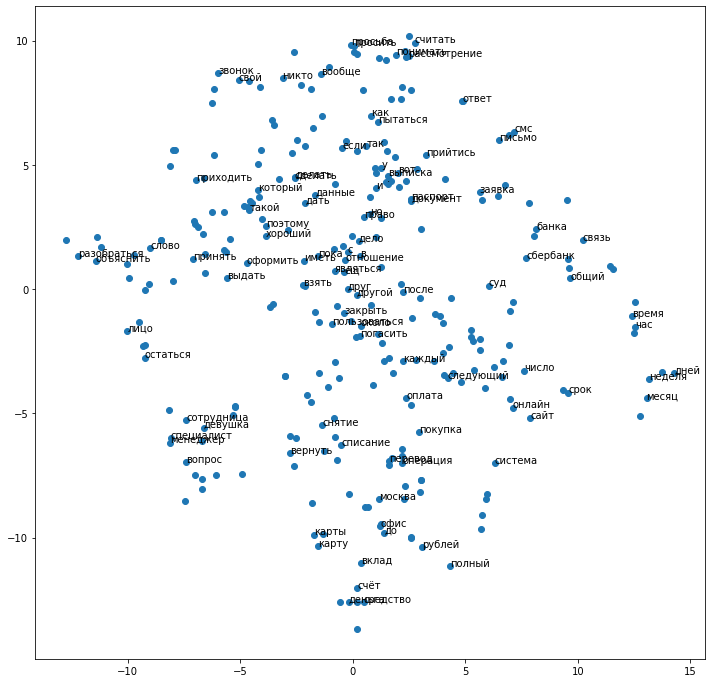

In [167]:
import matplotlib.pyplot as plt
import random

random.seed(0)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)


indices = list(range(len(labels)))
selected_indices = random.sample(indices, 100)
for i in selected_indices:
        plt.annotate(labels[i,1], (x_vals[i], y_vals[i]))

Хорошо видно внизу кластер "**сотрудница-девушка-менеджер-специалист**" , слева "**разобраться-объяснить**", справа **"дней-неделя-месяц"**

In [92]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

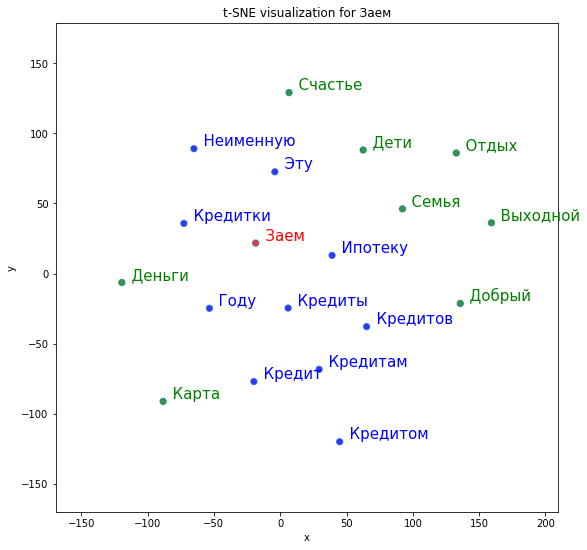

In [163]:
tsnescatterplot(model, 'заем', ['счастье', 'деньги', 'отдых', 'выходной', 'дети', 'семья', 'карта', 'добрый'])

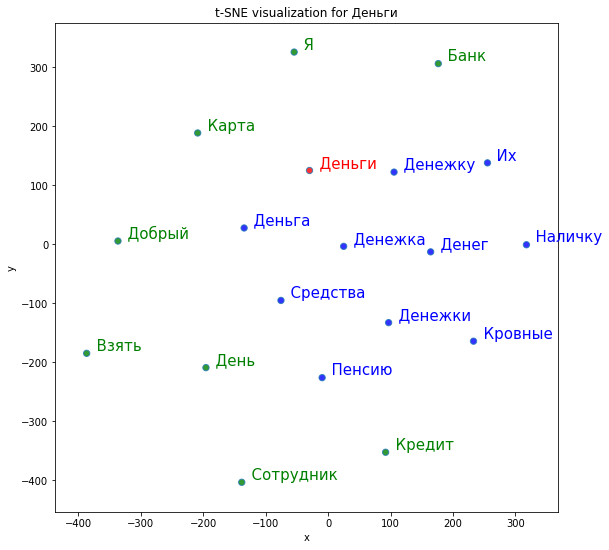

In [93]:
tsnescatterplot(model, 'деньги', ['кредит', 'банк', 'сотрудник', 'взять', 'день', 'я', 'карта', 'добрый'])

На картинке выше модель подобрала 10 наиболее **близких** слов (синий цвет) к заданному (красный цвет) и для сравнения уровня близости показываем нашу подборку слов (зеленый цвет).

Здесь зеленым выведены слова наиболее **отдаленные** от выбранного (красным), а синим близкие:

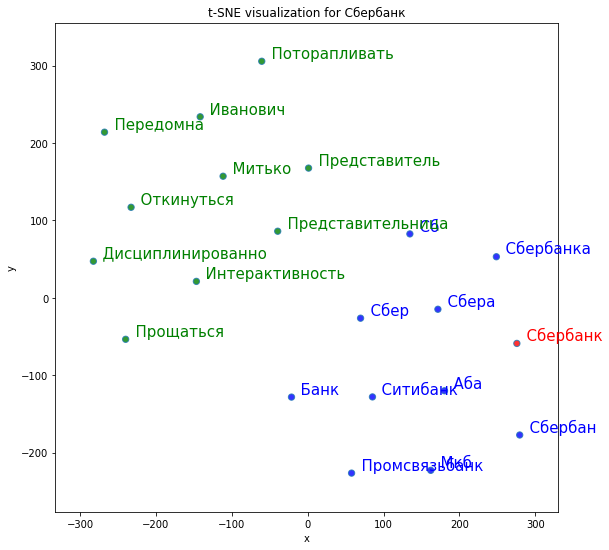

In [94]:
tsnescatterplot(model, 'сбербанк', [i[0] for i in model.wv.most_similar(negative=["сбербанк"])])

In [95]:
result = result.set_index('word')
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
word,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.,0.146588,-0.072885,-0.012787,-0.069309,0.007689,-0.068595,0.058654,-0.110600,0.095369,-0.097948,0.070809,0.028021,0.127409,-0.051145,0.099135,0.078114,-0.004043,-0.219593,0.045580,-0.066946,0.063469,-0.121290,0.136537,-0.056336,-0.087450,-0.030101,-0.043464,0.006469,0.111733,-0.027525,-0.161516,-0.025128,-0.140279,-0.018173,0.097011,-0.140563,0.050694,0.059228,0.017297,0.074351,...,-0.260779,-0.137912,0.068988,0.108588,-0.166903,0.224077,-0.167496,-0.014894,-0.224167,-0.109443,-0.110975,-0.005622,-0.106189,-0.120131,0.183558,-0.079896,0.017143,-0.024433,0.056322,-0.076144,-0.063037,-0.012135,0.076756,0.073079,-0.022070,0.082707,-0.084587,-0.044789,0.078664,0.062148,0.038050,-0.037210,0.039464,-0.056785,0.021764,-0.048579,0.026215,-0.078571,0.025745,0.027773
банк,-0.055658,0.185689,-0.005111,0.065515,0.049189,-0.017405,0.059149,-0.193651,0.015410,-0.032104,-0.143600,0.256856,-0.053310,0.090864,-0.017329,-0.086721,0.087401,-0.140041,0.043217,0.096971,0.147788,-0.034350,0.002973,-0.072182,-0.297146,0.135104,0.104876,-0.116527,-0.125100,0.166082,0.044175,0.091179,0.094903,0.052939,-0.087983,0.034082,0.056801,-0.104434,0.145419,-0.083905,...,-0.145335,-0.075928,0.050831,-0.011091,-0.000943,-0.103102,0.075584,0.059692,-0.023784,0.022794,-0.109131,-0.134161,0.033041,-0.012221,0.139010,-0.100179,0.152910,-0.046825,-0.005352,-0.011775,-0.106126,0.039960,0.109166,-0.149699,0.011426,-0.020095,0.107998,-0.104461,0.029549,0.031654,-0.036511,0.010156,-0.094499,0.066775,-0.170173,0.202370,0.083309,0.160987,0.028668,-0.047651
!,0.044886,-0.066071,0.131806,-0.074232,0.142548,0.042839,0.136339,-0.090141,0.090962,0.144388,0.045760,0.035962,-0.044117,-0.066768,0.091715,0.229243,-0.063636,-0.180251,-0.002385,0.013998,-0.037700,-0.031225,0.055930,0.030447,-0.070881,-0.087135,-0.005530,-0.079528,-0.068810,0.045877,-0.180821,0.011905,-0.024716,0.147009,-0.079447,-0.019461,-0.058637,0.043494,-0.068557,0.066587,...,-0.145606,0.029518,0.041925,-0.018074,-0.048481,0.154243,-0.015990,-0.079122,-0.186354,-0.046940,-0.005067,-0.084164,0.020724,-0.025648,0.019193,-0.152414,-0.047702,0.034595,-0.123320,-0.021602,0.004380,0.151589,0.070678,0.108479,-0.260573,-0.120272,0.014621,-0.044468,-0.074518,0.124348,-0.010284,0.069950,0.064253,-0.042752,0.105859,-0.137802,0.028831,0.081194,-0.064037,0.027222
карта,-0.159630,-0.008255,-0.112533,0.044126,-0.100482,0.043030,0.146449,-0.221877,-0.137862,-0.243143,0.023720,-0.022136,0.029237,-0.086745,-0.157222,-0.059171,-0.049085,0.028522,0.004704,-0.129063,0.007182,0.151872,0.232324,0.082689,-0.070905,0.005186,0.151652,-0.023559,0.108400,-0.089836,-0.128430,0.198635,0.029184,-0.215834,-0.135186,-0.003183,0.002446,0.016381,-0.019279,-0.048036,...,0.042968,-0.006216,-0.106699,0.209241,0.041806,-0.011062,-0.071111,0.166229,-0.055471,-0.007912,-0.111377,0.065664,-0.036182,0.059734,-0.114115,-0.084849,-0.080323,-0.075758,0.097908,-0.067439,0.020113,0.026156,0.081094,0.140001,0.150179,-0.040378,-0.051712,0.028795,-0.028548,0.101190,-0.077787,-0.066181,0.003211,-0.137477,0.067828,0.073554,-0.130044,0.001809,0.002102,0.127274
?,-0.058839,-0.047917,0.015478,-0.021128,0.141657,0.053596,0.211287,0.031188,0.054986,-0.122224,0.195326,0.010462,0.055777,-0.007521,0.155394,0.166441,-0.133137,-0.144280,-0.023639,0.041163,0.062885,-0.030279,0.102106,-0.111304,-0.061570,-0.065212,0.083129,-0.134321,-0.150609,0.037829,-0.256839,-0.100558,-0.040557,0.169352,-0.140417,-0.007312,-0.065121,0.069750,0.006792,0.025386,...,-0.129820,-0.035991,0.114686,0.012226,0.065723,0.010254,-0.090930,-0.112310,-0.142905,0.059005,0.098959,-0.017258,0.014226,-0.028033,-0.095503,-0.147900,0.098268,0.063118,-0.029688,0.005511,-0.010909,0.128906,-0.03

In [96]:
def most_similar(result, word, n=5, exceptions=[]):
    """Return the n most similar words"""
    return result.loc[~result.index.isin(exceptions)].dot(word).sort_values(ascending=False).head(n)

def op(operation, n=1):
    """Compute the vector addition "w1 - w2 + w3" and return the n most similar words
        equation: w1 - w2 + w3 = w4
        analogy: (w2 is to w3) as (w1 is to w4)
    """
    w1, w2, w3 = operation.split()[::2]
    vec = result.loc[w1] - result.loc[w2] + result.loc[w3]
   
    topn =  most_similar(
        result, vec, 
        exceptions=[w1, w2, w3],
        n=n+3
    )
    analogy = "%s   относится к   %s как %s   относится к    %s" % (w2, w3, w1, "?")
    top_res = ["%s = %s (%.2f)" % (analogy, topn.index[i], topn[i]) for i in range(n)]
    print("\n".join(top_res))


**Отношения** между словами:

In [97]:
op("банк - деньги + сотрудник")
op("банк - отказать + система")
op("сбербанк - быстро + деньги")
op("я - банк + деньги")

деньги   относится к   сотрудник как банк   относится к    ? = специалист (0.71)
отказать   относится к   система как банк   относится к    ? = банкинг (1.09)
быстро   относится к   деньги как сбербанк   относится к    ? = сбербанка (1.03)
банк   относится к   деньги как я   относится к    ? = она (0.87)


In [160]:
op("он - она + женщина")
op("ленивый - пенсия - бедность")
op("авто - красный + розовый")

она   относится к   женщина как он   относится к    ? = мужчина (0.96)
пенсия   относится к   бедность как ленивый   относится к    ? = пофигистичный (1.16)
красный   относится к   розовый как авто   относится к    ? = машина (0.94)


### хорошо-плохо
 - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [98]:
def word2viz_plot(result, words, x_op, y_op, labels=None):

    dfs = result.iloc[result.index.isin(words)]
    x2, x1 = x_op.split(" - ")
    y2, y1 = y_op.split(" - ")
    x_label = "%s --------> %s" % (x1, x2)
    y_label = "%s --------> %s" % (y1, y2)
    
    word_labels = dfs.index if labels is None else labels
    #print(word_labels)
    dfs["x"] = dfs.iloc[:,:100].dot(result.loc[x2] - result.loc[x1])
    dfs["y"] = dfs.iloc[:,:100].dot(result.loc[y2] - result.loc[y1])

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)

    for i in range(len(dfs)):
        x, y, text = dfs.iloc[i]["x"], dfs.iloc[i]["y"], word_labels[i]
        ax.scatter(x, y, alpha=0.9, cmap='rainbow')
        ax.text(x, y, text, alpha=0.9)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()

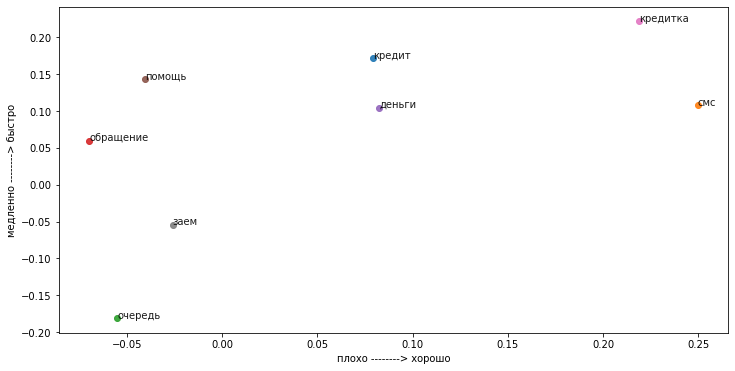

In [123]:
nd_list = ["очередь","деньги", "кредит", "кредитка", "заем", "смс", "обращение", "помощь"]

word2viz_plot(result, nd_list, "хорошо - плохо", "быстро - медленно")

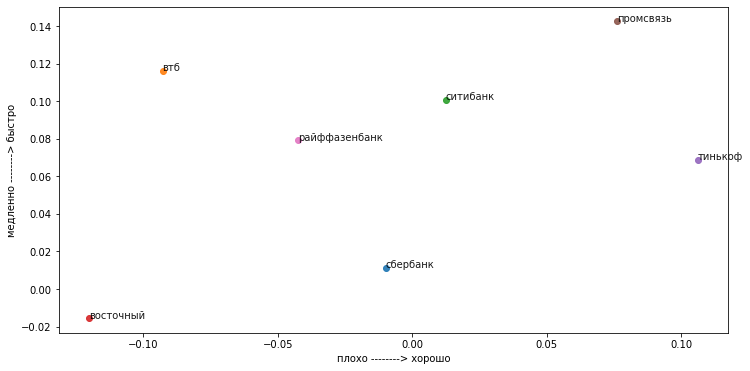

In [125]:
word2viz_plot(result, [ "сбербанк", "восточный", "втб", "ситибанк", "промсвязь","райффазенбанк","тинькоф"], "хорошо - плохо", "быстро - медленно")


- тот же пример разбор вручную по шагам

In [197]:
v1 = result.loc["плохо"]  - result.loc["хорошо"]
v2 = result.loc["медленно"] - result.loc["быстро"] 
v1

0    -0.077887
1     0.146772
2    -0.149899
3     0.067040
4     0.029036
        ...   
95    0.012704
96    0.050443
97    0.050736
98    0.025479
99   -0.061139
Length: 100, dtype: float64

In [201]:
wx = result.loc["сбербанк"].dot(v2)
wy = result.loc["сбербанк"].dot(v1)

wx1 = result.loc["промсвязьбанк"].dot(v2)
wy1 = result.loc["промсвязьбанк"].dot(v1)

In [203]:
wy

0.009894963483350483

In [204]:
wx

-0.011340718793205529

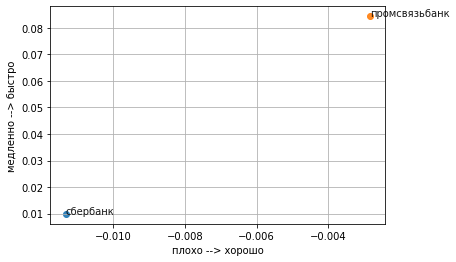

In [202]:
import numpy as np
import matplotlib.pyplot as plt
x = wx
y = wy
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.9)
ax.text(x, y, 'сбербанк', alpha=0.9)
ax.grid()
x = wx1
y = wy1
ax.scatter(x, y, alpha=0.9)
ax.text(x, y, 'промсвязьбанк', alpha=0.9)
ax.set_xlabel('плохо --> хорошо')   
ax.set_ylabel('медленно --> быстро')
plt.show()